In [29]:
import abtem
import dask
import numpy as np
import scrapbook as sb
from ase.cluster import Decahedron
from dask.distributed import Client
from dask.distributed.deploy.utils import nprocesses_nthreads
from dask.system import CPU_COUNT
from distributed.diagnostics import MemorySampler

In [30]:
gpts = 256
sampling = 0.05
num_configs = None
n_workers = None
threads_per_worker = None
fft_threads = 1
interpolation = None

In [31]:
if interpolation is None:
    interpolation = max(gpts // 256, 1)

if num_configs is None:
    num_configs = max(8192 // gpts, 1)

dask_threads = CPU_COUNT // fft_threads
n_workers, threads_per_worker = nprocesses_nthreads(dask_threads)

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: xlabel='x [Å]', ylabel='y [Å]'>)

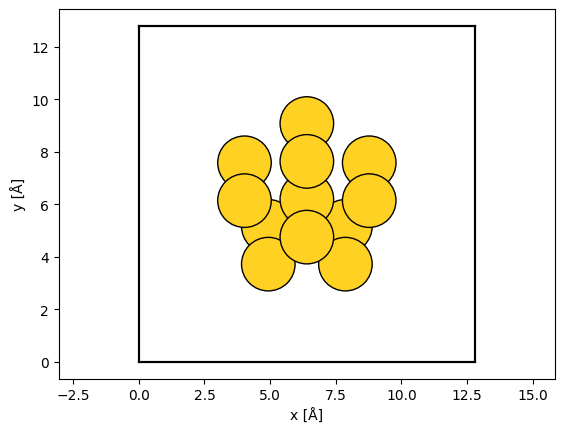

In [32]:
extent = gpts * sampling
slope = 0.19908323698251337

p = int(np.floor(slope * extent))
q = max(p // 4, 2)

atoms = Decahedron("Au", p, q, 0)
atoms.rotate("x", 30)
atoms.cell[0, 0] = atoms.cell[1, 1] = extent
atoms.center()
atoms.center(axis=2, vacuum=4)

abtem.show_atoms(atoms)

In [6]:
client = Client(n_workers=n_workers, threads_per_worker=threads_per_worker)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 31.93 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:51910,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 31.93 GiB
Comm: tcp://127.0.0.1:51935,Total threads: 4
Dashboard: http://127.0.0.1:51937/status,Memory: 7.98 GiB
Nanny: tcp://127.0.0.1:51914,


In [33]:
frozen_phonons = abtem.FrozenPhonons(
    atoms, num_configs=num_configs, sigmas=0.1, ensemble_mean=True
)

potential = abtem.Potential(
    frozen_phonons, gpts=gpts, slice_thickness=2, projection="infinite"
)
s_matrix = abtem.SMatrix(
    potential=potential,
    energy=100e3,
    semiangle_cutoff=20,
    downsample=True,
    interpolation=interpolation,
)

detector = abtem.AnnularDetector(inner=80, outer=240)

scan = abtem.GridScan()

scan.match_probe(s_matrix)

s_matrix.cutoff_angles

(245.79852389511072, 245.79852389511072)

In [34]:
measurements = s_matrix.reduce(scan=scan, detectors=detector)

In [15]:
memory_sampler = MemorySampler()

In [22]:
%%timeit -n1 -r1 -o
with memory_sampler.sample():
    with abtem.config.set({"fftw.threads": fft_threads}):
        measurements.compute()

2.42 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 2.42 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [23]:
timeit_result = _

In [24]:
time_per_phonon = timeit_result.average / num_configs
print("Time per phonon", time_per_phonon, "s")

Time per phonon 7.547500001692242e-05 s


<AxesSubplot: xlabel='time', ylabel='Cluster memory (GiB)'>

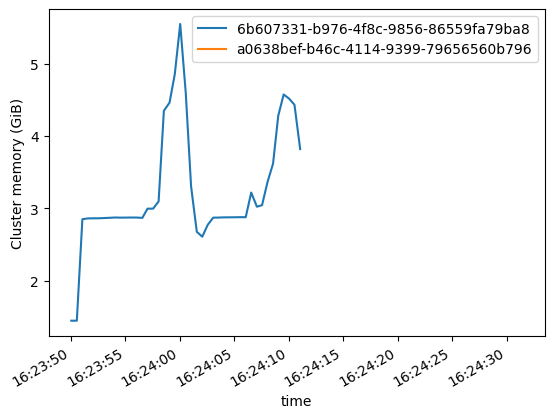

In [25]:
memory_sampler.plot()

In [26]:
peak_memory = max([memory for time, memory in list(memory_sampler.samples.values())[0]])
peak_memory = peak_memory * 9.31323e-10
print("Peak memory", peak_memory, "GiB")

Peak memory 5.550509127008255 GiB


In [27]:
sb.glue("time_per_phonon", time_per_phonon)
sb.glue("peak_memory", peak_memory)
sb.glue("num_probe_positions", int(np.prod(scan.shape)))

(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='x [Å]', ylabel='y [Å]'>)

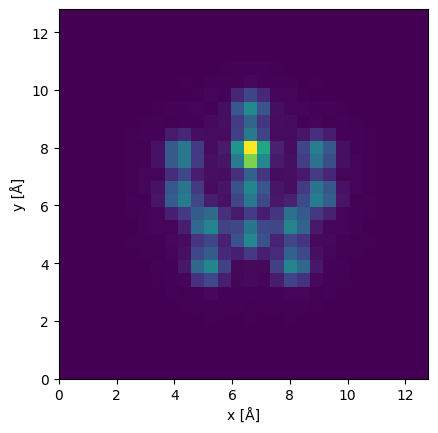

In [28]:
measurements.show()